In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from cooltools.lib import numutils

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

In [2]:
from akita_utils.format_io import h5_to_df
from akita_utils.tsv_gen_utils import filter_dataframe_by_column

In [3]:
import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import average_stat_over_targets
from analysis_utils import split_by_percentile_groups

2024-03-01 12:16:58.039085: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 12:16:58.039166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 12:16:58.040007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 12:16:58.046562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 12:16:59.562133: W tensorflow/compiler/tf2

In [4]:
# for all directories with results:
# python collect_jobs_and_clean.py /scratch2/smaruj/<directory> -v -l -n

In [5]:
# stat metric the analysis is based on
stat_of_analysis_interest = "SCD"
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_flanks/single_insertion_flanks"

In [6]:
# reading and averaging data for model 0 only
df_m0 = h5_to_df(data_dir+"/model_0_bg_0.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=["insertion_SCD", "disruption_SCD"]) 
df_m0_tg = average_stat_over_targets(df_m0, model_index=0, head_index=1, stat=stat_of_analysis_interest)

In [7]:
df_split_SCDins = split_by_percentile_groups(df_m0_tg, column_to_split="insertion_SCD", num_classes=5, 
                               upper_percentile=100, lower_percentile=0, 
                               category_colname="insSCD_group")

In [8]:
# group 4 is the stronges, group 0 the weakest

In [9]:
# splitting bin-wise

# df_m0_tg["dSCD_cat"] = pd.cut(x=df_m0_tg["disruption_SCD"], bins=[0, 18, 36, 66, 84, 91], 
#                      labels=["Low_dSCD", "UpperLow_dSCD", "Medium_dSCD", "LowerHigh_dSCD", "High_dSCD"]) 

In [10]:
flank_df = df_split_SCDins.groupby(["insSCD_group", "flank_bp"]).agg({"SCD_m0": "mean"}).reset_index()

In [11]:
color_dict = {"Group_0": "#9fc2e0",
              "Group_1": "#6da3d0",
              "Group_2":"#3b7fb9", 
              "Group_3":"#2d618e", 
              "Group_4":"#1d3f5c"}

## Plot with sites splited into 5 groups by percentiles

Text(0, 0.5, 'single insertion SCD')

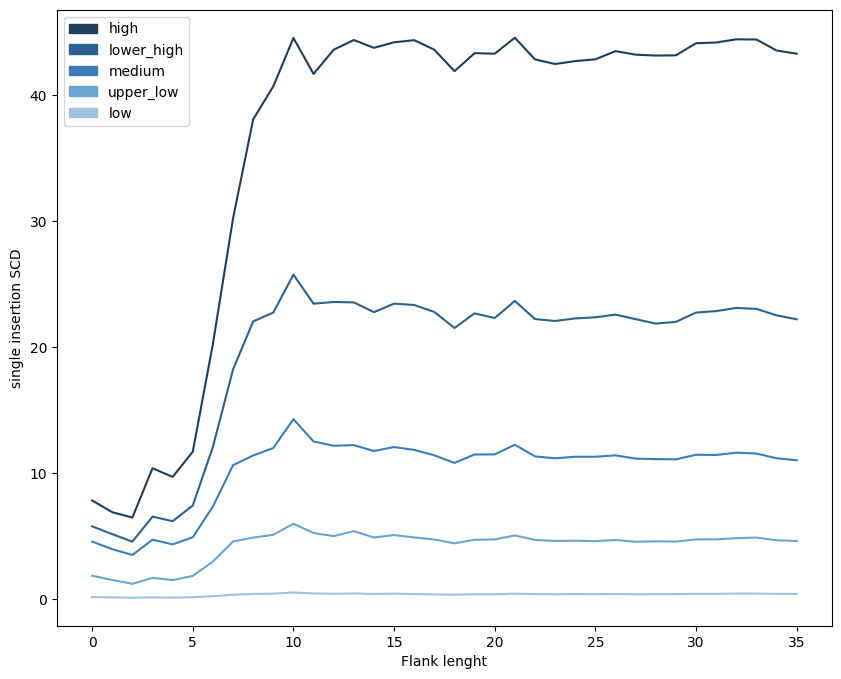

In [12]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, flank_df[(flank_df["insSCD_group"] == group)]["SCD_m0"], 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr3_patch = mpatches.Patch(color="#2d618e", label="lower_high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr1_patch = mpatches.Patch(color="#6da3d0", label="upper_low")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("single insertion SCD")
# plt.legend(loc="upper left")

## Plot with smoothed lines

In [13]:
bin_size = 11

Text(0, 0.5, 'single insertion SCD')

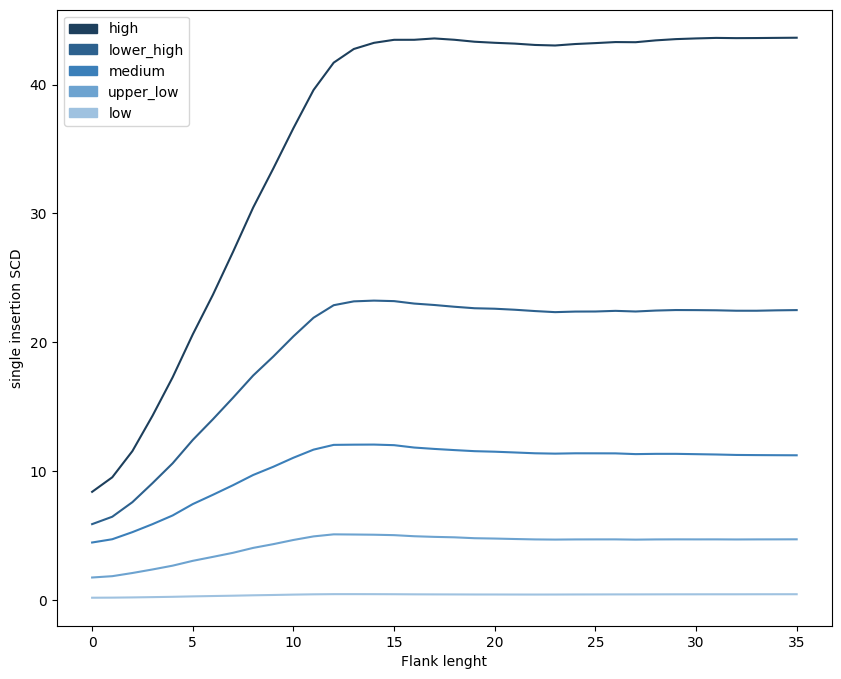

In [14]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD_m0"], bin_size), 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr3_patch = mpatches.Patch(color="#2d618e", label="lower_high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr1_patch = mpatches.Patch(color="#6da3d0", label="upper_low")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("single insertion SCD")
# plt.legend(loc="upper left")

## Plot with smoothed lines and 25-75 percentile bands

In [15]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [16]:
insSCDpercentiles_df = df_split_SCDins.groupby(["insSCD_group", "flank_bp"])["SCD_m0"].agg(
    percentile25 = percentile(25), percentile75 = percentile(75)).reset_index()

Text(0, 0.5, 'single insertion SCD')

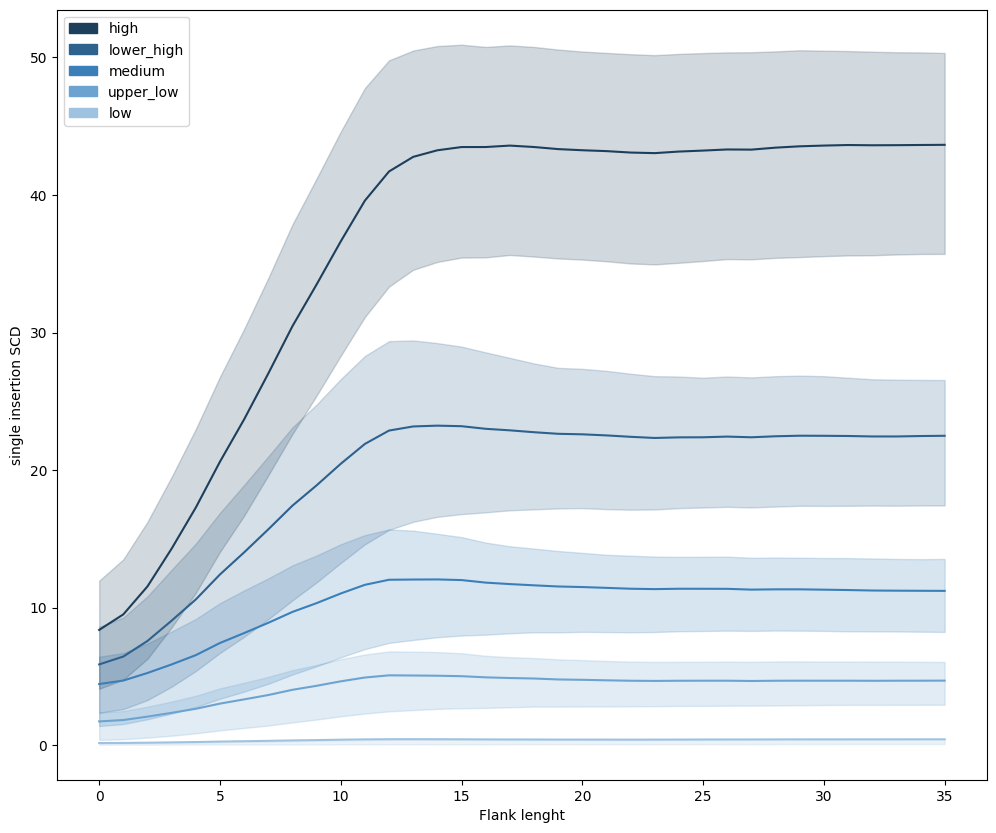

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD_m0"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   


gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr3_patch = mpatches.Patch(color="#2d618e", label="lower_high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr1_patch = mpatches.Patch(color="#6da3d0", label="upper_low")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("single insertion SCD")
# plt.legend(loc="upper left")

## Plotting 10 random sites from high, medium, low insertion_SCD group

In [18]:
num_sites = 10
ten_high = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_4"].start.unique(), size=num_sites)
ten_medium = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_2"].start.unique(), size=num_sites)
ten_low = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_0"].start.unique(), size=num_sites)

In [19]:
to_plot = df_split_SCDins[df_split_SCDins['start'].isin(ten_high)][["chrom", "end", "start", "strand"]].drop_duplicates().reset_index(drop=True)

In [20]:
to_plot.to_csv("random_10sites_top_class.tsv", sep="\t", index=False, header=True)

Text(0, 0.5, 'single insertion SCD')

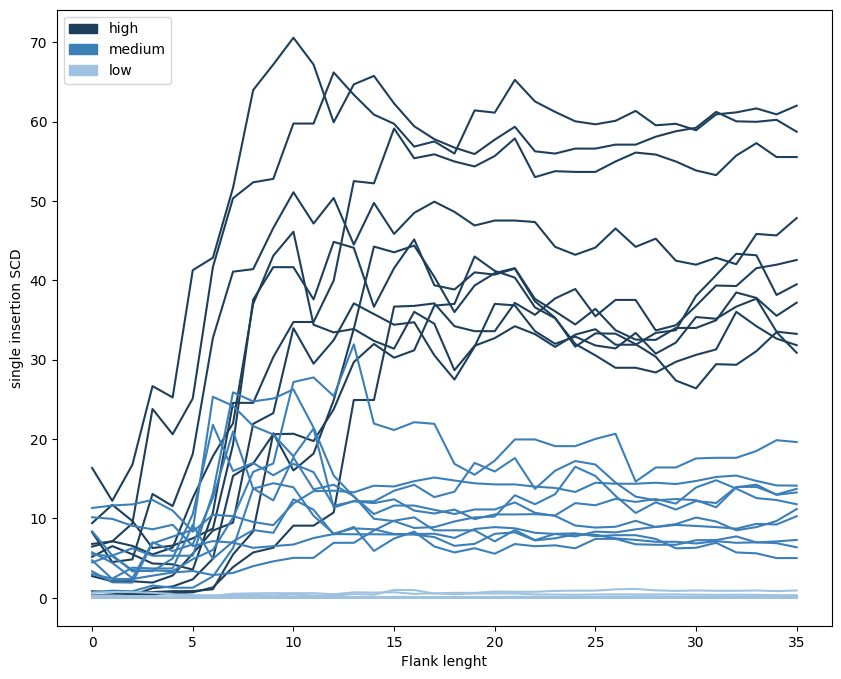

In [21]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for start_pos in ten_high:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD_m0"], color="#1d3f5c")

for start_pos in ten_medium:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD_m0"], color="#3b7fb9")

for start_pos in ten_low:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD_m0"], color="#9fc2e0")

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr2_patch, gr0_patch], loc="upper left")

# # plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("single insertion SCD")

## Plot with smoothed trends of 5 classes overlayed with 10 lines randomly chosen from the 'High'

Text(0, 0.5, 'single insertion SCD')

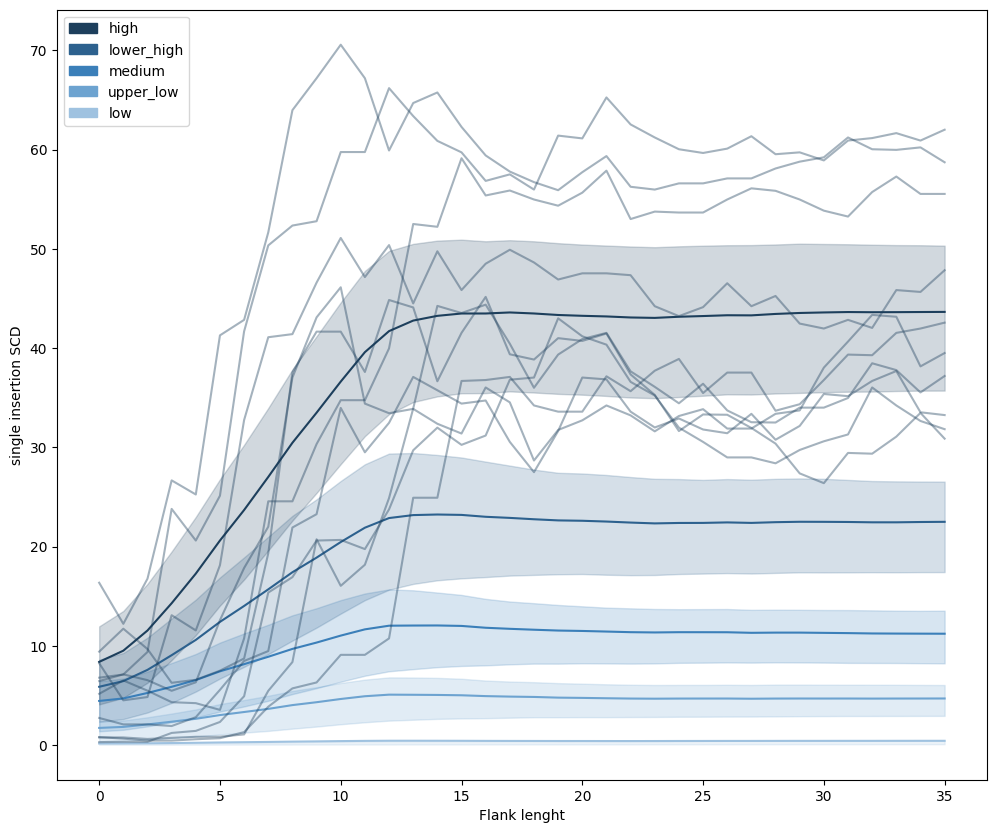

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD_m0"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

for start_pos in ten_high:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD_m0"], color="#1d3f5c", alpha=0.4)

gr4_patch = mpatches.Patch(color="#1d3f5c", label="high")
gr3_patch = mpatches.Patch(color="#2d618e", label="lower_high")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="medium")
gr1_patch = mpatches.Patch(color="#6da3d0", label="upper_low")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="low")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Flank lenght")
plt.ylabel("single insertion SCD")
# plt.legend(loc="upper left")